In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [4]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [5]:
SAMPLING_FREQUENCY = 1500

In [6]:
from src.spike_train import simulate_poisson_process
firing_rate = np.ones((1500, 1000)) * 10
firing_rate[:750, :] = 5
spike_train = simulate_poisson_process(firing_rate, SAMPLING_FREQUENCY)
t = (np.arange(0, 1500) / SAMPLING_FREQUENCY)[: , np.newaxis] * np.ones((1, 1000)) - 0.500

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


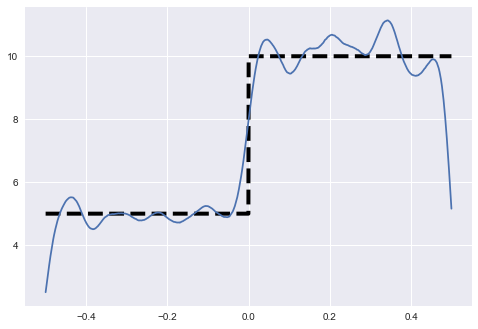

In [8]:
from src.spike_train import perievent_time_kernel_density_estimate

plt.plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4)
plt.plot(np.unique(t), perievent_time_kernel_density_estimate(spike_train, SAMPLING_FREQUENCY));

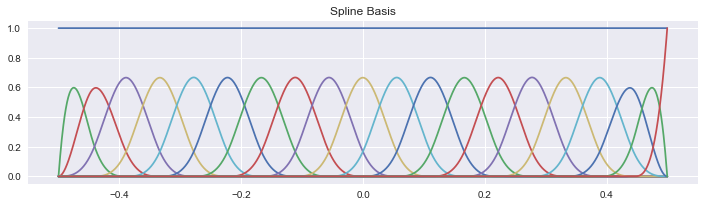

In [333]:
formula='bs(time, df=20)'
design_matrix = dmatrix(formula, dict(time=t.ravel()),
                            return_type='dataframe')
predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], dict(time=np.unique(t)))[0]

fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharey=True)

for data in predict_design_matrix.T:
    axes.plot(np.unique(t), data)
    
axes.set_title('Spline Basis');

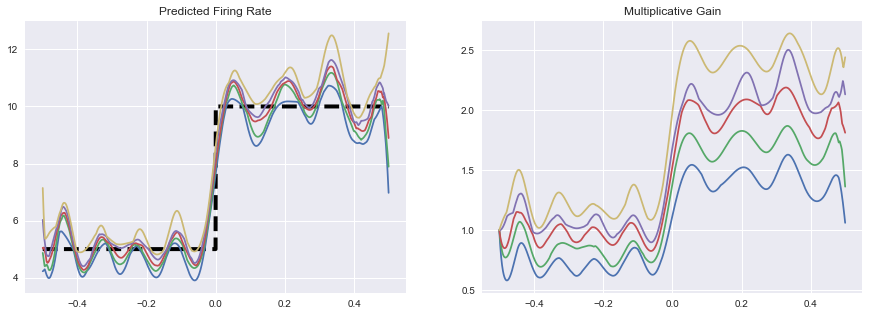

In [9]:
from src.spike_train import perievent_time_spline_estimate


spline_estimate = perievent_time_spline_estimate(spike_train.ravel(), t.ravel(), SAMPLING_FREQUENCY,
                                                 formula='bs(time, df=20)', n_boot_samples=10)

fig, axes = plt.subplots(1, 2, figsize=(15, 5));
axes[0].plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4)
axes[0].plot(np.unique(t),
         spline_estimate.firing_rate.quantile(
             [.025, .25, .5, .75, .975], 'n_boot_samples').to_pandas().T);
axes[0].set_title('Predicted Firing Rate')

axes[1].plot(np.unique(t),
         spline_estimate.multiplicative_gain.quantile(
             [.025, .25, .5, .75, .975], 'n_boot_samples').to_pandas().T);
axes[1].set_title('Multiplicative Gain');

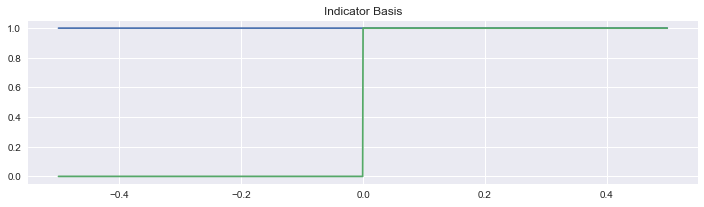

In [1661]:
formula='bs(time, knots=[0], degree=0)'
design_matrix = dmatrix(formula, dict(time=t.ravel()),
                            return_type='dataframe')
predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], dict(time=np.unique(t)))[0]

fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharey=True)

for data in predict_design_matrix.T:
    axes.plot(np.unique(t), data)
    
axes.set_title('Indicator Basis');

AttributeError: 'Dataset' object has no attribute 'firing_rate_change_over_time'

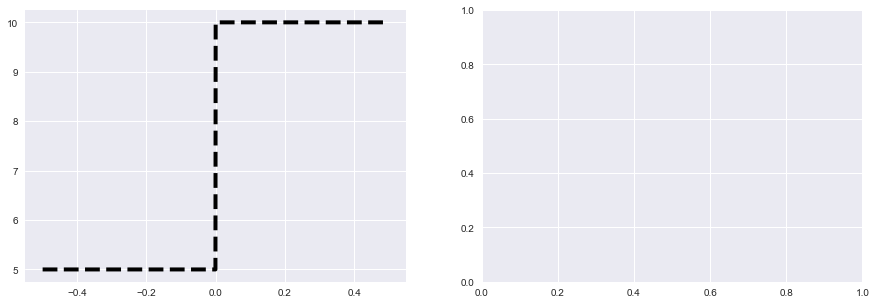

In [13]:
from src.spike_train import perievent_time_spline_estimate

indicator_estimate = perievent_time_spline_estimate(spike_train.ravel(), t.ravel(), SAMPLING_FREQUENCY,
                                                    formula='bs(time, knots=[0], degree=0)', n_boot_samples=100)

fig, axes = plt.subplots(1, 2, figsize=(15, 5));
axes[0].plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4)
axes[0].plot(np.unique(t), indicator_estimate.firing_rate.quantile(
             [.025, .25, .5, .75, .975], 'n_boot_samples').to_pandas().T);
axes[0].set_title('Predicted Firing Rate')

axes[1].plot(np.unique(t), indicator_estimate.multiplicative_gain.quantile(
             [.025, .25, .5, .75, .975], 'n_boot_samples').to_pandas().T);
axes[1].set_title('Multiplicative Gain');

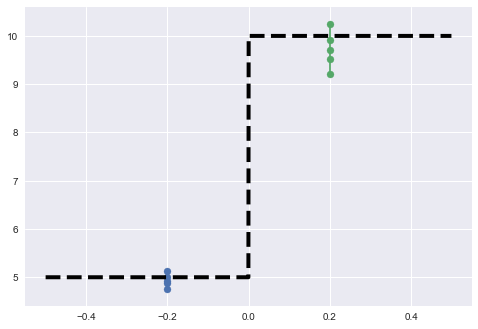

In [1164]:
from src.spike_train import perievent_time_indicator_estimate

plt.plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4)
indicator_estimate = perievent_time_indicator_estimate(
    spike_train.ravel(), t.ravel(), SAMPLING_FREQUENCY).quantile([.025, .25, .5, .75, .975], 'n_boot_samples')
plt.plot(np.ones((5,)) * -0.2, indicator_estimate.before0_firing_rate.values);
plt.scatter(np.ones((5,)) * -0.2, indicator_estimate.before0_firing_rate.values);
plt.plot(np.ones((5,)) * 0.2,
         indicator_estimate.before0_firing_rate.values +
         indicator_estimate.firing_rate_change_after0_vs_before0.values);
plt.scatter(np.ones((5,)) * 0.2,
         indicator_estimate.before0_firing_rate.values +
         indicator_estimate.firing_rate_change_after0_vs_before0.values);

0.0


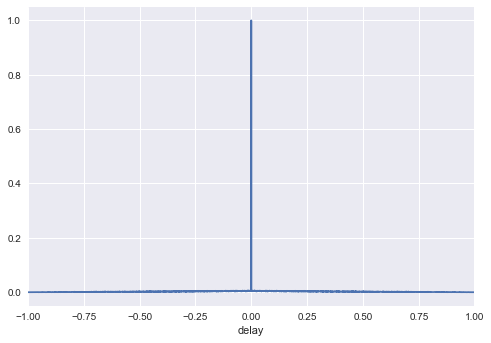

In [1345]:
from src.spike_train import cross_correlate

cross_correlate(spike_train, sampling_frequency=SAMPLING_FREQUENCY).plot();

print(cross_correlate(spike_train, sampling_frequency=SAMPLING_FREQUENCY).argmax())

0.5


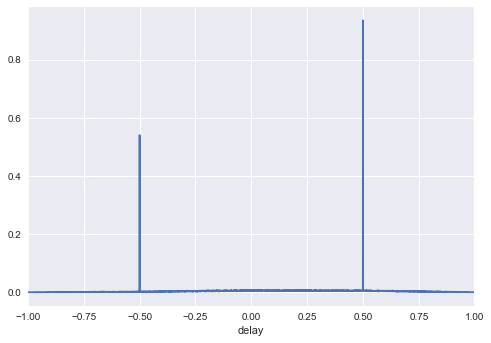

In [1344]:
spike_train2 = np.roll(spike_train, int(SAMPLING_FREQUENCY * 0.500), axis=0)

cross_correlate(spike_train, spike_train2, sampling_frequency=SAMPLING_FREQUENCY).plot();

print(cross_correlate(spike_train, spike_train2, sampling_frequency=SAMPLING_FREQUENCY).argmax())

In [8]:
from patsy import dmatrix
from statsmodels.api import GLM, families

from src.time_rescale import TimeRescaling
trial_id = np.arange(spike_train.shape[1])[np.newaxis, :] * np.ones((spike_train.shape[0], 1))

design_matrix = dmatrix('bs(time, df=5)', dict(time=t.ravel()),
                        return_type='dataframe')
fit = GLM(spike_train.ravel(), design_matrix, family=families.Poisson()).fit()

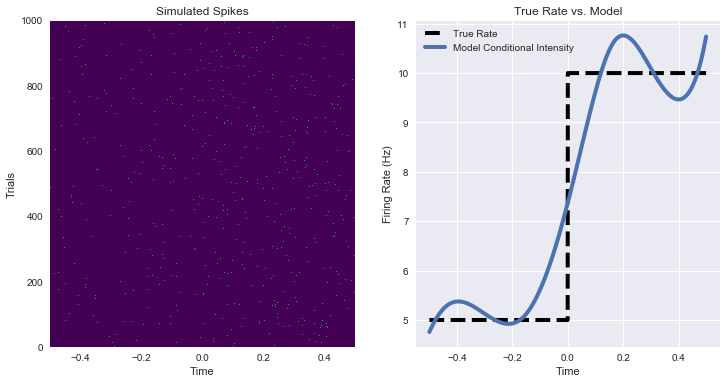

In [44]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].pcolormesh(np.unique(t), np.unique(trial_id), spike_train.T, cmap='viridis');
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Trials');
axes[0].set_title('Simulated Spikes')
conditional_intensity = fit.mu

axes[1].plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4, label='True Rate')
axes[1].plot(t.ravel(), conditional_intensity * SAMPLING_FREQUENCY, linewidth=4, label='Model Conditional Intensity');
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Firing Rate (Hz)')
axes[1].set_title('True Rate vs. Model');
plt.legend();

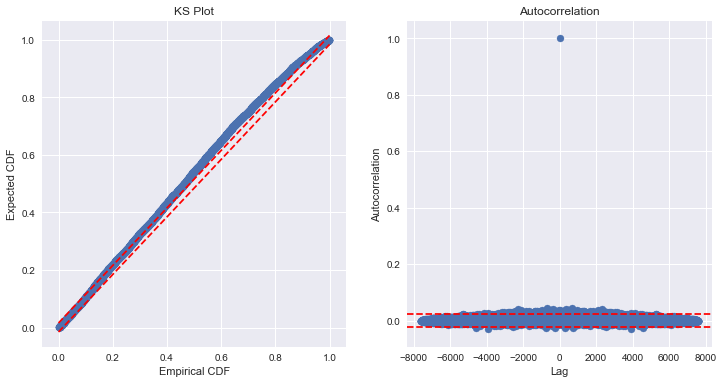

In [45]:
from src.time_rescale import TimeRescaling

rescaled = TimeRescaling(conditional_intensity, spike_train.ravel(), trial_id.ravel())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rescaled.plot_ks(ax=axes[0])
axes[0].set_title('KS Plot')
rescaled.plot_rescaled_ISI_autocorrelation(ax=axes[1])
axes[1].set_title('Autocorrelation');

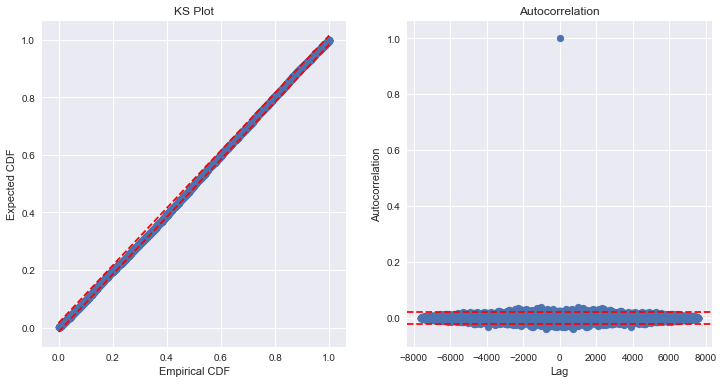

In [46]:
rescaled = TimeRescaling(conditional_intensity, spike_train.ravel(), trial_id.ravel(),
                         adjust_for_short_trials=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rescaled.plot_ks(ax=axes[0])
axes[0].set_title('KS Plot')
rescaled.plot_rescaled_ISI_autocorrelation(ax=axes[1])
axes[1].set_title('Autocorrelation');

In [48]:
from patsy import dmatrix
from statsmodels.api import GLM, families

from src.time_rescale import TimeRescaling
trial_id = np.arange(spike_train.shape[1])[np.newaxis, :] * np.ones((spike_train.shape[0], 1))

constant_fit = GLM(spike_train.ravel(), np.ones_like(spike_train.ravel()), family=families.Poisson()).fit()

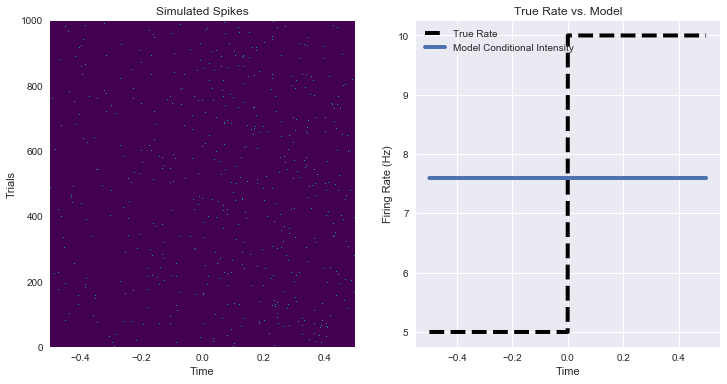

In [66]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].pcolormesh(np.unique(t), np.unique(trial_id), spike_train.T, cmap='viridis');
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Trials');
axes[0].set_title('Simulated Spikes')
conditional_intensity = fit.mu

axes[1].plot(np.unique(t), firing_rate[:, 0], linestyle='--', color='black', linewidth=4, label='True Rate')
axes[1].plot(t.ravel(), constant_fit.mu * SAMPLING_FREQUENCY, linewidth=4, label='Model Conditional Intensity');
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Firing Rate (Hz)')
axes[1].set_title('True Rate vs. Model');
plt.legend();

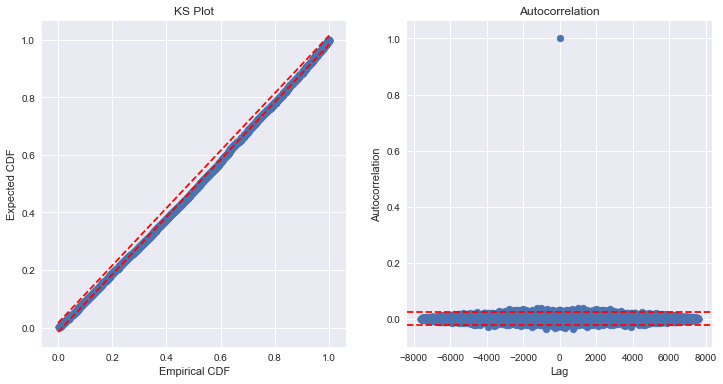

In [67]:
rescaled = TimeRescaling(constant_fit.mu, spike_train.ravel(), trial_id.ravel(),
                         adjust_for_short_trials=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rescaled.plot_ks(ax=axes[0])
axes[0].set_title('KS Plot')
rescaled.plot_rescaled_ISI_autocorrelation(ax=axes[1])
axes[1].set_title('Autocorrelation');

In [1817]:
covariate = np.ones((spike_train.shape[1],))
covariate[:spike_train.shape[1] // 2] = 0
covariate = covariate * np.ones((spike_train.shape[0], 1))
covariate = np.where(covariate, 'b', 'a')
covariate = pd.Series(covariate.ravel())

design_matrix = dmatrix(
    'bs(time, knots=[0], degree=0) * covariate', {'time': t.ravel(), 'covariate': covariate},
    return_type='dataframe')